In [1]:
import tensorflow as tf
print(tf.__version__)

# !pip install -q tensorflow-datasets

2.3.0


In [ ]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)


In [3]:
!python --version

Python 3.6.9


In [5]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


In [23]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)


In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[3]))
print(training_sentences[3])

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 102       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 160,109
Trainable params: 160,109
Non-trainable params: 0
_________________________________________________________________


In [25]:
num_epochs = 10
history=model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 7s 9ms/step - loss: 0.5552 - accuracy: 0.7410 - val_loss: 0.3958 - val_accuracy: 0.8303
Epoch 2/10
782/782 [==============================] - 7s 9ms/step - loss: 0.3319 - accuracy: 0.8625 - val_loss: 0.3298 - val_accuracy: 0.8584
Epoch 3/10
782/782 [==============================] - 7s 9ms/step - loss: 0.2701 - accuracy: 0.8905 - val_loss: 0.3320 - val_accuracy: 0.8566
Epoch 4/10
782/782 [==============================] - 7s 9ms/step - loss: 0.2342 - accuracy: 0.9086 - val_loss: 0.3479 - val_accuracy: 0.8520
Epoch 5/10
782/782 [==============================] - 7s 9ms/step - loss: 0.2078 - accuracy: 0.9226 - val_loss: 0.3708 - val_accuracy: 0.8460
Epoch 6/10
782/782 [==============================] - 7s 9ms/step - loss: 0.1871 - accuracy: 0.9324 - val_loss: 0.3929 - val_accuracy: 0.8410
Epoch 7/10
782/782 [==============================] - 7s 9ms/step - loss: 0.1694 - accuracy: 0.9391 - val_loss: 0.4184 - val_accuracy: 0.8388
Epoch 

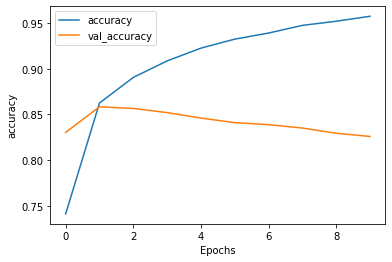

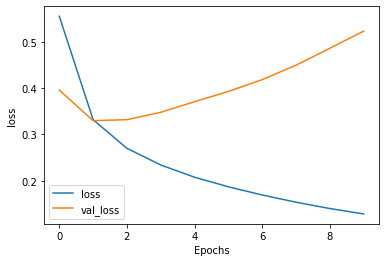

In [26]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [10]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [12]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [13]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

the above 2 cells work with tensorflow projector

In [18]:
sentence = "I really think this is amazing. honest."
sequence1 = tokenizer.texts_to_sequences([sentence])
print(sequence1)
padded = pad_sequences(sequence1, maxlen=max_length, truncating=trunc_type)
print(model.predict(padded))

[[11, 64, 102, 12, 7, 478, 1200]]
[[0.9651683]]
